# NLP Project

I've scraped the comments on a Reddit post about reviews of a videogame called "S.T.A.L.K.E.R. 2: Heart of Chornobyl".  
I will use NLP to determine themes in the comments with the goal of classifying them into groups.

My Results show me that we can classify the comments into these three subject categories, determined by examining their most important words:

1. **Feedback and bugs:** great, bugs, xbox, patches, patch
2. **AI and Engine:** ai, good, engine, bugs, veilguard (AI refering to the enemies in the game)
3. **Comparing with Cyberpunk:** cyberpunk, lol, yeah, hell, expected (Cyberpunk is a game that famously launched with a lot of bugs)
4. **Negative Feedback:** bugs, war, issues, jank, fixedAI

In [89]:
pip install praw

Note: you may need to restart the kernel to use updated packages.


In [90]:
import praw

# Set up Reddit client
reddit = praw.Reddit(
    client_id='DiCM3mSi_TzF_4HTPocmuw',
    client_secret='secret!',
    user_agent='pa_rApp'
)

# Fetch a post
post_url = 'https://www.reddit.com/r/Games/comments/1gvq4zj/stalker_2_heart_of_chornobyl_review_thread/'
post = reddit.submission(url=post_url)

# Collect comments
post.comments.replace_more(limit=None)
comments = [comment.body for comment in post.comments.list()]

# Print
print(comments[:5])

['I\'m not big enough to get our channel & review up there in the pinned post but have been playing it during the review process so happy to answer any questions.\n\nThe game has a lot of bugs. Some will dismiss it as Eurojank, or "Yeah that\'s STALKER bay bee!" And they\'re right, those little fun bugs are there, corpses flying in to the sky, or legs sticking out the ground, standing in chairs, or disabled NPCs standing and walking normally. Those aren\'t breaking anything. There are some larger ones involving quests becoming hardlocked, or progress hitting a wall, and those are more problematic as they can cause you frustration beyond fun. I had to restart 3 times, and was unable to score the game because of it.\n\nBUT, I mention this because I wanted to just say, GSC Game World patched the game 5 times during the review period that I was aware of, 2 of them big patches. One so large I had to check if it was the Day 0 and was told no which was insane. They are working at such a pace 

In [91]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))
custom_stopwords = stop_words.union({'like','game','games','wořk','comapny','mean','play','honestly','saying','check','different','review',
                                    'far','day','way','people','time','apparently','think','reviews','felt','look','things','got',
                                    'replaced','know','quite','played','comapny gsc','playing','channel','stalker','going','actually',
                                    'removed','deleted','clear','really','eurojank','oh','wait','lot'})

def clean_text_advanced(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word.lower() not in custom_stopwords]
    return " ".join(tokens)

# Apply to comments
cleaned_comments = [clean_text_advanced(comment) for comment in comments]


[nltk_data] Downloading package stopwords to C:\Users\Pascal
[nltk_data]     Annand\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Pascal
[nltk_data]     Annand\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [92]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Apply TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_features=2000)
X = vectorizer.fit_transform(cleaned_comments)

print(X.shape)  # (number of comments, number of features)


(1042, 2000)


In [93]:
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation

# Fit LDA model
n_topics = 4
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(X)

# Get the top words for each topic
num_words = 5

# Displaying the top words for each topic
for topic_idx, topic in enumerate(lda.components_):
    # Get the top words' indices for the current topic (sort by word importance)
    top_word_indices = topic.argsort()[-num_words:][::-1]
    top_words = [vectorizer.get_feature_names_out()[i] for i in top_word_indices]
    print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")



Topic #1: bugs, issues, bad, great, ll
Topic #2: bugs, pc, xbox, ai, issues
Topic #3: engine, good, ue5, ai, performance
Topic #4: war, single, ukraine, jank, buggy


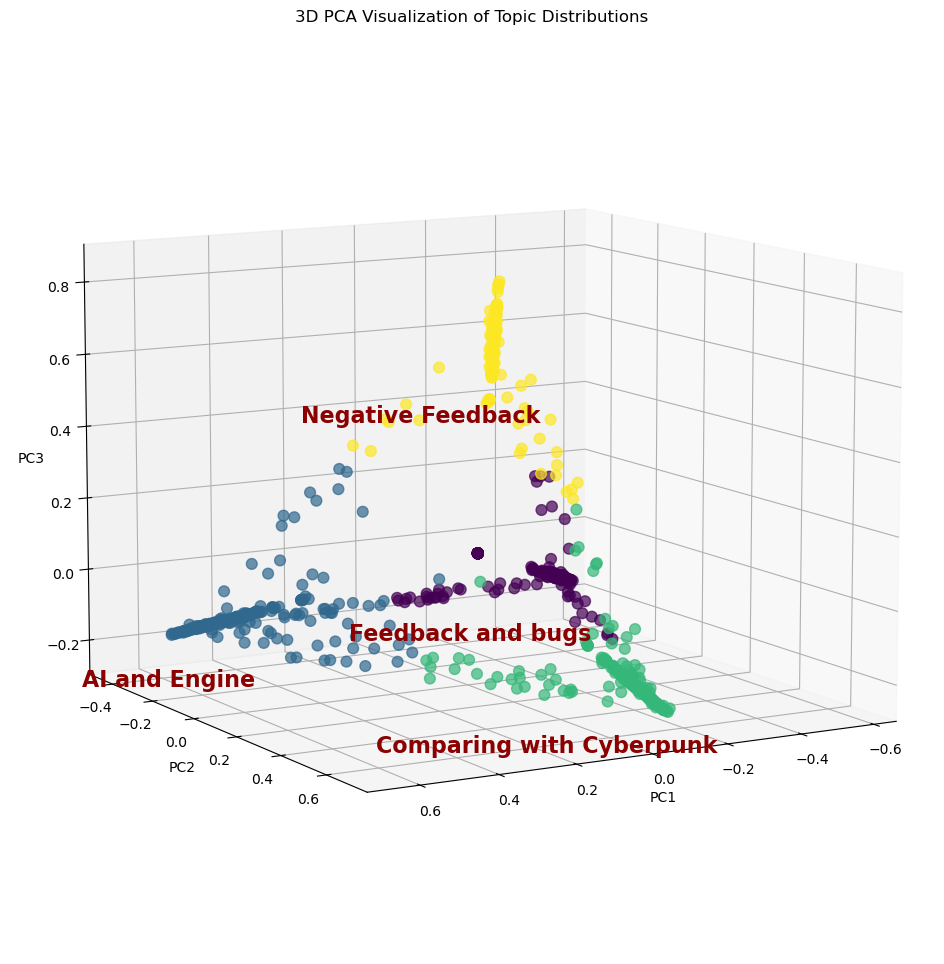

In [94]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Get topic distributions for each comment
topic_distributions = lda.transform(X)  

# Perform PCA to reduce the topic distribution
pca = PCA(n_components=3)
reduced_data_3d = pca.fit_transform(topic_distributions)

# 3D PCA plot
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with topic color mapping
scatter = ax.scatter(
    reduced_data_3d[:, 0], reduced_data_3d[:, 1], reduced_data_3d[:, 2],
    c=np.argmax(topic_distributions, axis=1),  # Color by topic (find the dominant topic for each comment)
    cmap='viridis', alpha=0.7, s=60)  # Transparency and size of points

# Add grid and labels
ax.grid(True)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA Visualization of Topic Distributions')

# Set the elevation and azimuthal angle for better depth perception
ax.view_init(elev=10, azim=60)

# Custom labels for each cluster (based on LDA topic words)
custom_labels = {
    0: "Feedback and bugs",        # Topic 1
    1: "AI and Engine",     # Topic 2
    2: "Comparing with Cyberpunk",   # Topic 3
    3: "Negative Feedback",
}

# Define an offset to place the labels above the clusters
label_offset = -0.15  # Adjust this value to move labels higher or lower

# Loop over each topic and calculate the centroid of each cluster
n_topics = len(np.unique(np.argmax(topic_distributions, axis=1)))  # Get number of topics (clusters)

for topic_idx in range(n_topics):
    # Find the indices of points belonging to this topic
    topic_indices = np.argmax(topic_distributions, axis=1) == topic_idx
    topic_points = reduced_data_3d[topic_indices]
    
    # Calculate the centroid of the current cluster (mean of the points)
    centroid = topic_points.mean(axis=0)
    
    # Add label at the centroid, with an offset in the Z direction
    # Here, I'm modifying the x coordinate to shift the labels to the left.
    # Reduce the x-coordinate by a fixed amount to move the label to the left.
    ax.text(centroid[0] + 0.2, centroid[1], centroid[2] + label_offset,  # Shift left by 0.3 units on x-axis
            custom_labels[topic_idx], 
            color='darkred', fontsize=16, fontweight='bold', alpha=1, 
            horizontalalignment='center', verticalalignment='center')

# Show the plot
plt.show()